In [1]:
import sys
sys.path.append("../script/")

import Functions
from Engine import Engine


from sklearn.metrics import classification_report,accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
import importlib
from time import time
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
import numpy as np
import pandas as pd
from time import time

In [2]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.utils import shuffle
def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based of the probabilities
    """
    
    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    print(roc_auc_score(true_y,prob[:,1]))

# data

In [4]:
df = pd.read_csv("../data/connect-4.tsv",delimiter='\t')
X = df.iloc[:,:-1].to_numpy().astype("float")
y = df.iloc[:,-1].to_numpy().astype("int")

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.5,stratify=y)

# model

In [5]:
def to_one_hot(y,yt):
    le = LabelEncoder()
    ohe = OneHotEncoder()
    y_train = le.fit_transform(y)
    y_one_hot = ohe.fit_transform(y_train.reshape(-1,1))
    
    y_test = le.transform(yt)
    yt_one_hot = ohe.transform(y_test.reshape(-1,1))
    
    return y_train,y_test,y_one_hot,yt_one_hot

def initial(y_one_hot):
    init_log_odds = np.sum(y_one_hot,axis=0)/y_one_hot.shape[0]
    
    init_p = np.exp(init_log_odds)
    init_p = init_p/(1+init_p)

    return init_log_odds,init_p

def initial_first_bin(init_log_odds,init_p,X):
    log_odds = np.repeat(init_log_odds,X.shape[0],0)
    p = np.repeat(init_p,X.shape[0],0)
    
    return log_odds,p
    
def update_log_p(grads,log_odds,p,learning_rate):
    log_odds_1 = log_odds + learning_rate * grads
    
    p_1 = np.exp(log_odds_1,where=log_odds_1 < 16,out=np.zeros(log_odds_1.shape)+16)
    p_1 = np.divide(p_1,(1+p_1),where=p_1 < 16,out=np.ones(p_1.shape))
    
    # p_1 = np.exp(log_odds_1)
    # p_1 = np.divide(p_1,(1+p_1))

    return log_odds_1,p_1

def predict(X,init_log_odds,init_p,learning_rate,stack):
    log_odds,p = initial_first_bin(init_log_odds,init_p,X)

    for node in stack:
        grads = node.predict_grad(X)
        
        log_odds,p = update_log_p(grads,log_odds,p,learning_rate)
    return p

In [8]:
train_acc = []
test_acc = []

stack = []

y_train,y_test,y_train_one_hot,y_test_one_hot = to_one_hot(y_train,y_test)

init_log_odds,init_p = initial(y_train_one_hot)
log_odds,p = initial_first_bin(init_log_odds,init_p,X_train)

test_log_odds,test_p = initial_first_bin(init_log_odds,init_p,X_test)

In [16]:
learning_rate = 0.1
bins = 2
lam = 0
stack = []
losses = []
num_features = X_train.shape[1]

max_depth = 6
tolerance = 0.0005


total_size = 10
elite_size = 10

eg = Engine(Functions.simple_opset,X_train,y_train,y_train_one_hot,learning_rate,bins,max_depth,lam)
eg.initialize_nodes(log_odds,p)
origin_features = eg.nodes.copy()
origin_losses = eg.losses.copy()

# stack.extend(eg.nodes)
# losses.extend(origin_losses)

for i in range(300):
    for j in range(6):
        eg.evolve(total_size,elite_size,log_odds=log_odds,p=p,tolerance=tolerance,verbose=0)
    stack,losses = eg.adding_unique_node(stack,losses,eg.nodes[num_features:],tolerance=tolerance)
    eg.nodes = origin_features.copy()
    eg.losses = origin_losses.copy()
    print(len(stack),sum([n.numNode for n in stack]),i)
    # if len(stack) > 8000:
    #         break


23 145 0
45 413 1
60 488 2
86 814 3
98 880 4
110 960 5
118 1006 6
127 1041 7
140 1158 8
154 1260 9
161 1281 10
168 1326 11
173 1343 12
175 1347 13
193 1535 14
198 1550 15
220 1794 16
239 2055 17
248 2132 18
255 2153 19
263 2139 20
274 2226 21
280 2294 22
287 2437 23
290 2380 24
294 2412 25
294 2394 26
306 2530 27
309 2559 28
311 2571 29
312 2570 30
320 2570 31
326 2634 32
329 2661 33
332 2678 34
338 2726 35
347 2815 36
348 2812 37
348 2802 38
354 2864 39
362 2932 40
364 2948 41
364 2930 42
370 2990 43
370 2982 44
379 3089 45
381 3091 46
379 3069 47
379 3063 48
381 3079 49
381 3065 50
382 3050 51
382 3032 52
386 3064 53
388 3066 54
390 3054 55
392 3070 56
392 3066 57
393 3081 58
396 3102 59
404 3158 60
410 3196 61
415 3235 62
416 3236 63
420 3254 64
421 3245 65
422 3236 66
425 3283 67
433 3359 68
433 3347 69
435 3357 70
437 3361 71
439 3377 72
439 3369 73
440 3374 74
446 3456 75
454 3526 76
455 3535 77
457 3537 78
460 3542 79
462 3568 80
471 3671 81
470 3664 82
470 3658 83
472 3664 84
4

0.7692877020545917 0.7673406554368098 0.7676959057402528
10830.793044572943 10935.980338928712 10935.980338928712
0.7835869500858547 0.7794487699458243 0.779537582521685
10179.780031261475 10369.39351594783 10369.39351594783
0.790958612114394 0.7845110867698866 0.7845702951537937
9860.8441184334 10107.14462704417 10107.109410190405
0.7962579193557937 0.7884188401077593 0.78850765268362
9651.349798124027 9943.168489640988 9943.053319781644
0.7994256616732784 0.7913792593031174 0.7916753012226532
9496.550722149943 9827.287347326148 9827.14800683402
0.8012611759133164 0.793451552739868 0.7937475946594038
9374.550382390025 9739.354189831638 9739.21489639953
0.8035111611107821 0.7945469078421504 0.7948429497616862
9273.775749557157 9670.135305267888 9670.032575965266
0.8054947006927586 0.7955830545605258 0.7959975132478759
9189.62100242179 9613.864676734283 9613.777135192955
0.8069453490437563 0.7968560348145297 0.7971816809260192
9116.15081737256 9567.487638367407 9567.424605595574
0.80821

KeyboardInterrupt: 

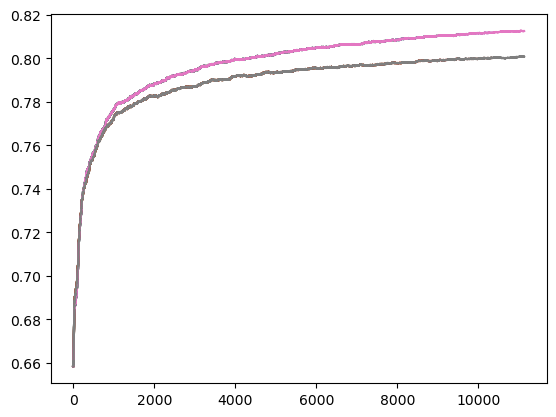

In [17]:
def training_data(node,y_train_one_hot,log_odds,p,test_log_odds=None,test_p=None):
    grads = node.estimator.set_grads_bin(y_train_one_hot-p,p)
    log_odds,p = update_log_p(grads,log_odds,p,learning_rate)

    if test_log_odds != None:
        test_grads = node.predict_grad(X_test)
        test_log_odds,test_p = update_log_p(test_grads,test_log_odds,test_p,learning_rate)

        return log_odds,p,test_log_odds,test_p
    
    return log_odds,p

def get_order(stack,y_train_one_hot,log_odds,p,previous_sse):
    score = []
    
    for node in stack:
        log_odds,p = training_data(node,y_train_one_hot,log_odds,p)
        
        sse = np.sum(np.power(y_train_one_hot - p,2))
        score.append(previous_sse - sse)
        previous_sse = sse
    
    return [stack[i] for i in np.argsort(score)[::-1]]

y_train,y_test,y_train_one_hot,y_test_one_hot = to_one_hot(y_train,y_test)

fits = [i.estimator.loss for i in stack]
a = [stack[i] for i in np.argsort(fits)]

log_odds,p = initial_first_bin(init_log_odds,init_p,X_train)
test_log_odds,test_p = initial_first_bin(init_log_odds,init_p,X_test)

# a = get_order(a,y_train_one_hot,log_odds,p,previous_sse=np.sum(np.power(y_train_one_hot - p,2)))

train_acc = []
test_acc = []

train_sse = []
test_sse = []


counts = []

for _ in range(100):
    score = []
    
    for i,node in enumerate(a):
        # node.estimator.lam =  1
        node.estimator.lam =  0
        grads = node.estimator.set_grads_bin(y_train_one_hot-p,p)
        log_odds,p = update_log_p(grads,log_odds,p,learning_rate)

        test_grads = node.predict_grad(X_test)
        test_log_odds,test_p = update_log_p(test_grads,test_log_odds,test_p,learning_rate)


        train_sse.append(np.sum(np.power(y_train_one_hot - p,2)))
        test_sse.append(np.sum(np.power(y_test_one_hot - test_p,2)))
        # score.append(previous_sse - train_sse[-1])
        # previous_sse = train_sse[-1]


        pred = np.argmax(p,axis=1)
        train_acc.append(accuracy_score(pred,y_train))
        test_pred = np.argmax(test_p,axis=1)
        test_acc.append(accuracy_score(test_pred,y_test))
    
    # a = [a[i] for i in np.argsort(score)[::-1]]

    plt.plot(train_acc)
    plt.plot(test_acc)
    print(train_acc[-1],test_acc[-1],max(test_acc))

    # plt.plot(train_sse)
    # plt.plot(test_sse)
    print(train_sse[-1],test_sse[-1],min(test_sse))

    # plt.legend(["train","test"])
    # plt.show()
    

In [32]:
sum([n.numNode for n in stack])

4131

              precision    recall  f1-score   support

           0    0.66536   0.26388   0.37789      3225
           1    0.78718   0.80943   0.79815      8317
           2    0.87969   0.94738   0.91228     22236

    accuracy                        0.84816     33778
   macro avg    0.77741   0.67356   0.69611     33778
weighted avg    0.83645   0.84816   0.83316     33778

              precision    recall  f1-score   support

           0    0.50725   0.18455   0.27064      3224
           1    0.75379   0.77807   0.76574      8318
           2    0.86649   0.93596   0.89989     22237

    accuracy                        0.82536     33779
   macro avg    0.70917   0.63286   0.64542     33779
weighted avg    0.80445   0.82536   0.80679     33779



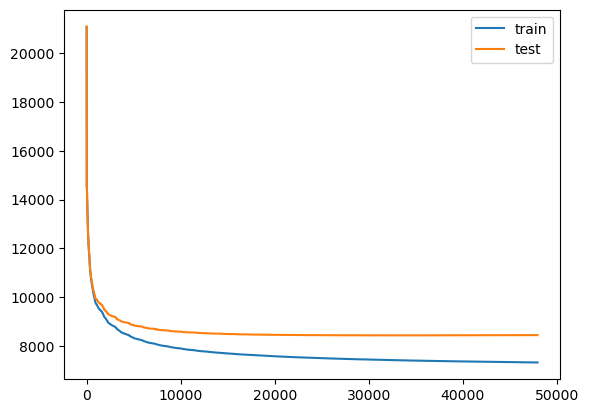

In [33]:
plt.plot(train_sse)
plt.plot(test_sse)
plt.legend(["train","test"])    
print(classification_report(y_train,np.argmax(p,axis=1),digits=5))
print(classification_report(y_test,np.argmax(test_p,axis=1),digits=5))

In [28]:
sum([n.numNode for n in stack])

13385

              precision    recall  f1-score   support

           0    0.76238   0.38202   0.50899      3225
           1    0.83359   0.86125   0.84719      8317
           2    0.90530   0.95957   0.93165     22236

    accuracy                        0.88022     33778
   macro avg    0.83375   0.73428   0.76261     33778
weighted avg    0.87400   0.88022   0.87050     33778

              precision    recall  f1-score   support

           0    0.50171   0.22705   0.31262      3224
           1    0.77499   0.79586   0.78529      8318
           2    0.87880   0.93970   0.90823     22237

    accuracy                        0.83626     33779
   macro avg    0.71850   0.65420   0.66871     33779
weighted avg    0.81724   0.83626   0.82111     33779



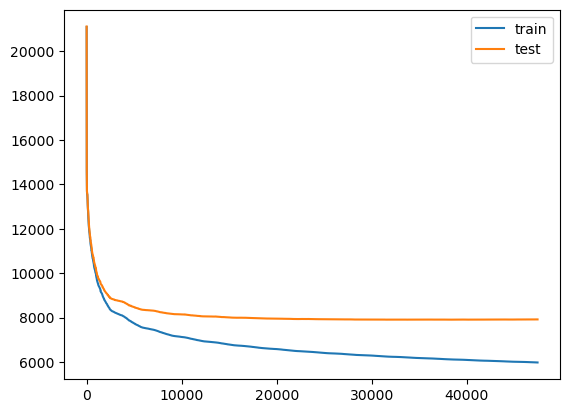

In [29]:
plt.plot(train_sse)
plt.plot(test_sse)
plt.legend(["train","test"])    
print(classification_report(y_train,np.argmax(p,axis=1),digits=5))
print(classification_report(y_test,np.argmax(test_p,axis=1),digits=5))

# Decision Tree

In [40]:
from sklearn.tree import DecisionTreeClassifier

In [41]:
clf = DecisionTreeClassifier()
clf.fit(X_train,y_train)

print(classification_report(y_train,clf.predict(X_train)))
print(classification_report(y_test,clf.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3225
           1       1.00      1.00      1.00      8317
           2       1.00      1.00      1.00     22236

    accuracy                           1.00     33778
   macro avg       1.00      1.00      1.00     33778
weighted avg       1.00      1.00      1.00     33778

              precision    recall  f1-score   support

           0       0.23      0.24      0.23      3224
           1       0.61      0.61      0.61      8318
           2       0.83      0.83      0.83     22237

    accuracy                           0.72     33779
   macro avg       0.56      0.56      0.56     33779
weighted avg       0.72      0.72      0.72     33779



# XGBoost

In [17]:
import xgboost


In [19]:
xgb = xgboost.XGBClassifier()
xgb.fit(X_train,y_train)

print(classification_report(y_train,xgb.predict(X_train),digits=5))
print(classification_report(y_test,xgb.predict(X_test),digits=5))
print("train:",np.sum(np.power(y_train_one_hot - xgb.predict_proba(X_train),2)))
print("test:",np.sum(np.power(y_test_one_hot - xgb.predict_proba(X_test),2)))

import json

def item_generator(json_input, lookup_key):
    if isinstance(json_input, dict):
        for k, v in json_input.items():
            if k == lookup_key:
                yield v
            else:
                yield from item_generator(v, lookup_key)
    elif isinstance(json_input, list):
        for item in json_input:
            yield from item_generator(item, lookup_key)

def tree_depth(json_text):
    json_input = json.loads(json_text)
    depths = list(item_generator(json_input, 'depth'))
    return max(depths) + 1 if len(depths) != 0 else 1


booster = xgb.get_booster()

tree_df = booster.trees_to_dataframe()
depths = [tree_depth(x) for x in booster.get_dump(dump_format = "json")]
len(depths),np.average(depths),len(tree_df)

              precision    recall  f1-score   support

           0    0.81226   0.26295   0.39728      3225
           1    0.82894   0.83612   0.83252      8317
           2    0.88265   0.96636   0.92261     22236

    accuracy                        0.86713     33778
   macro avg    0.84128   0.68848   0.71747     33778
weighted avg    0.86270   0.86713   0.85027     33778

              precision    recall  f1-score   support

           0    0.55156   0.14764   0.23293      3224
           1    0.77641   0.76064   0.76845      8318
           2    0.85477   0.95202   0.90077     22237

    accuracy                        0.82812     33779
   macro avg    0.72758   0.62010   0.63405     33779
weighted avg    0.80653   0.82812   0.80445     33779

train: 6639.30341242796
test: 8243.144500939688


(300, 6.0, 29000)

# GDBT

In [20]:
from sklearn.ensemble import GradientBoostingClassifier

In [21]:
clf = GradientBoostingClassifier(max_depth=5,n_estimators=100)
clf.fit(X_train,y_train)

print(classification_report(y_train,clf.predict(X_train),digits=5))
print(classification_report(y_test,clf.predict(X_test),digits=5))
print("train:",np.sum(np.power(y_train_one_hot - clf.predict_proba(X_train),2)))
print("test:",np.sum(np.power(y_test_one_hot - clf.predict_proba(X_test),2)))

len(clf.estimators_),sum([ est.tree_.node_count for ests in clf.estimators_ for est in ests])

              precision    recall  f1-score   support

           0    0.77586   0.06977   0.12802      3225
           1    0.78288   0.68198   0.72896      8317
           2    0.81351   0.96011   0.88075     22236

    accuracy                        0.80662     33778
   macro avg    0.79075   0.57062   0.57924     33778
weighted avg    0.80238   0.80662   0.77151     33778

              precision    recall  f1-score   support

           0    0.54478   0.04529   0.08362      3224
           1    0.75554   0.65136   0.69959      8318
           2    0.80440   0.95283   0.87235     22237

    accuracy                        0.79197     33779
   macro avg    0.70157   0.54982   0.55185     33779
weighted avg    0.76759   0.79197   0.75453     33779

train: 9334.191083645377
test: 9938.522806330135


(100, 18252)